In [27]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
from torchvision import transforms
from scipy.ndimage import gaussian_filter
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def gray(image):
    R = image[0]
    G = image[1]
    B = image[2]
    tensor = 0.299 * R + 0.587 * G + 0.114 * B
    return tensor


In [3]:
import cv2 as cv

In [4]:
img0 = cv.imread('test.jpg')

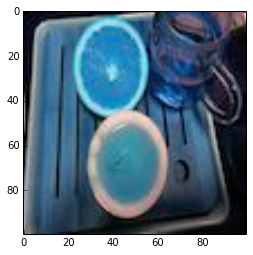

In [5]:
plt.imshow(img0)

In [6]:
transform1 = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    ]
)

In [7]:
img = transform1(img0)

In [8]:
print(img.size())

torch.Size([3, 100, 100])


In [9]:
img = Variable(torch.FloatTensor(img))

In [10]:
img1 = gray(img)

In [11]:
print(img1.size())

torch.Size([100, 100])


In [12]:
img2 = img1.data.numpy()

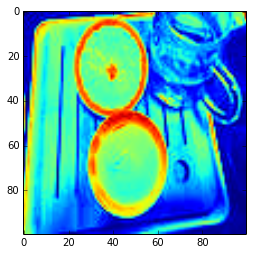

In [13]:
plt.imshow(img2)

In [14]:
def batch_gray(images):
    batch_size = images.size()[0]
    h = images.size()[2]
    w = images.size()[3]
    
    result = Variable(torch.zeros([batch_size, h, w]))    
    for i in xrange(batch_size):
        result[i] = gray(images[i])
    
    return result


In [15]:
batch_images = torch.cat([img.unsqueeze(0), img.unsqueeze(0)], dim=0)

In [16]:
batch_images.size()

torch.Size([2, 3, 100, 100])

In [17]:
batch_result = batch_gray(batch_images)
print(img.size())

torch.Size([3, 100, 100])


In [18]:
def gaussian_blur(image):
    
    blurred = cv.GaussianBlur(image, ksize=(0,0), sigmaX=3)
    return blurred
img3 = gaussian_blur(img0)

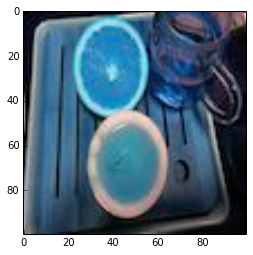

In [19]:
plt.imshow(img0)

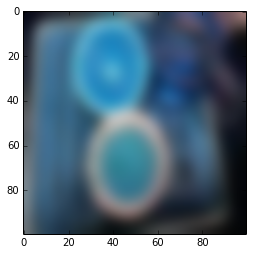

In [20]:
plt.imshow(img3)

In [21]:
transform2 = transforms.Compose([
    transforms.ToPILImage(),
])

img11 = transform2(img.data)
        

In [22]:
print(img11)

<PIL.Image.Image image mode=RGB size=100x100 at 0x11B305CD0>


In [23]:
img12 = np.asarray(img11)

In [24]:
def batch_gaussian(images):

    batch_size = images.size()[0]

    result = Variable(torch.zero(images.size()))

    for i in xrange(batch_size):

        img = images[i]
        img = transform2(img.data)
        img = np.asarray(img)
        blurred = cv.GaussianBlur(img, ksize=(0, 0), sigmaX=3)
        img = transform1(blurred)
        result[i] = img
        
    return result

In [25]:
result = batch_gaussian(batch_images)

TypeError: Type torch.FloatTensor doesn't implement stateless method zero

In [31]:
class Discriminator(nn.Module):

    def __init__(self, input_ch):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(input_ch, 48, 11, stride=4, padding=5)
        self.conv2 = nn.Conv2d(48, 128, 5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 192, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.conv4 = nn.Conv2d(192, 192, 3, padding=1)
        self.conv5 = nn.Conv2d(192, 128, 3, stride=2, padding=1)
        self.fc = nn.Linear(128*7*7, 1024)
        self.out = nn.Linear(1024, 2)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = F.relu(self.conv3(x))
        x = self.bn2(x)
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = F.relu(self.conv5(x))
        x = self.bn1(x)
        x = x.view(batch_size, 128*7*7)
        x = x.view(batch_size, 128*7*7)
        x = F.sigmoid(self.fc(x))
        x = F.softmax(self.out(x))
        return x

In [32]:
D = Discriminator(3)


In [33]:
D(batch_images)

Variable containing:
 0.4645  0.5355
 0.4645  0.5355
[torch.FloatTensor of size 2x2]

In [36]:
class ConvBlock(nn.Module):

    def __init__(self):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn = nn.BatchNorm2d(64)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.bn(x)
        x = F.relu(self.conv2(x))
        x = self.bn(x)

        return x

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 9, padding=4)
        self.blocks = nn.Sequential(
            ConvBlock(),
            ConvBlock(),
            ConvBlock(),
            ConvBlock(),
        )
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.blocks(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        return x

In [37]:
G = Generator()


In [39]:
p = G(batch_images)

In [40]:
print(p.size())

torch.Size([2, 64, 100, 100])
